\begin{center} 
Chun-Yuan (Scott) Chiu 
\end{center}
\begin{center} 
chunyuac@andrew.cmu.edu 
\end{center}

# 1. {-}

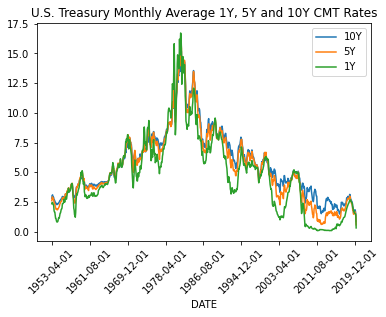

In [2]:
import pandas as pd

rates = pd.read_csv('fredgraph.csv', index_col=0)
rates.columns = [col.replace('GS', '') + 'Y' for col in rates.columns]
rates.plot(rot=45, title='U.S. Treasury Monthly Average 1Y, 5Y and 10Y CMT Rates')
pass

The augmented Dickey-Fuller test shows that all 3 time series are $\mathcal I(1)$. 

In [3]:
import statsmodels.tsa.api as smt
from pandas import DataFrame

smt.stattools.adfuller(rates['1Y'])[4]

{'1%': -3.4387291412780177,
 '5%': -2.8652383048736056,
 '10%': -2.568739332674375}

In [4]:
DataFrame({col: smt.stattools.adfuller(rates[col])[:2] for col in rates.columns}, index=['Test Statistic', 'p-value'])

,10Y,5Y,1Y
Test Statistic,-0.866806,-1.060174,-1.774502
p-value,0.798707,0.730690,0.393192


In [6]:
ratesdiff = rates.diff().dropna()

DataFrame({col: smt.stattools.adfuller(ratesdiff[col])[:2] for col in rates.columns}, index=['Test Statistic', 'p-value'])

,10Y,5Y,1Y
Test Statistic,-6.889457e+00,-6.814311e+00,-6.783201e+00
p-value,1.367493e-09,2.077893e-09,2.469366e-09


We perform the Phillips-Ouliaris test, the Engle-Granger test, and the Johansen test. All test results are consistent: All three pairs have cointegration. 

In [20]:
from arch.unitroot.cointegration import phillips_ouliaris, engle_granger
from itertools import combinations

for tnr1, tnr2 in combinations(rates.columns, 2):
    print(f'Tenor Pair: {tnr1, tnr2}')
    print('-------------------------')
    print(phillips_ouliaris(ratesdiff[tnr1], ratesdiff[tnr2]))
    print()
    print(engle_granger(ratesdiff[tnr1], ratesdiff[tnr2], trend='n'))
    print()

Tenor Pair: ('10Y', '5Y')
-------------------------
Phillips-Ouliaris zt Cointegration Test
Statistic: -25.681091711295867
P-value: 0.0
Null: No Cointegration, Alternative: Cointegration
Kernel: Bartlett
Bandwidth: 11.541
Trend: c
Distribution Order: 3

Engle-Granger Cointegration Test
Statistic: -22.512509228230552
P-value: 0.0
Null: No Cointegration, Alternative: Cointegration
ADF Lag length: 1
Trend: c
Estimated Root ρ (γ+1): -0.05707291974346895
Distribution Order: 1

Tenor Pair: ('10Y', '1Y')
-------------------------
Phillips-Ouliaris zt Cointegration Test
Statistic: -22.759071722778206
P-value: 0.0
Null: No Cointegration, Alternative: Cointegration
Kernel: Bartlett
Bandwidth: 7.1030
Trend: c
Distribution Order: 3

Engle-Granger Cointegration Test
Statistic: -14.260846670972638
P-value: 7.974381506338384e-29
Null: No Cointegration, Alternative: Cointegration
ADF Lag length: 3
Trend: c
Estimated Root ρ (γ+1): 0.1296649573334162
Distribution Order: 1

Tenor Pair: ('5Y', '1Y')
-----

In [55]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from itertools import combinations

for tnr1, tnr2 in combinations(rates.columns, 2):
    cj = coint_johansen(ratesdiff[[tnr1, tnr2]], det_order=0, k_ar_diff=0)
    print(f'Tenor Pair: {tnr1, tnr2}')
    print('-------------------------')
    print('Trace Statistics (for Rank > 0, Rank > 1): ', cj.trace_stat)
    print('Critical Values: ')
    print(DataFrame(cj.trace_stat_crit_vals, columns=['90%', '95%', '99%'], index=['Rank > 0', 'Rank > 1']))
    print()
    print('Maximum Eigenvalue Statistics: ', cj.max_eig_stat)
    print('Critical Values: ')
    print(DataFrame(cj.max_eig_stat_crit_vals, columns=['90%', '95%', '99%'], index=['Rank > 0', 'Rank > 1']))
    print()

Tenor Pair: ('10Y', '5Y')
-------------------------
Trace Statistics (for Rank > 0, Rank > 1):  [824.55898029 325.61219726]
Critical Values: 
              90%      95%      99%
Rank > 0  13.4294  15.4943  19.9349
Rank > 1   2.7055   3.8415   6.6349

Maximum Eigenvalue Statistics:  [498.94678303 325.61219726]
Critical Values: 
              90%      95%      99%
Rank > 0  12.2971  14.2639  18.5200
Rank > 1   2.7055   3.8415   6.6349

Tenor Pair: ('10Y', '1Y')
-------------------------
Trace Statistics (for Rank > 0, Rank > 1):  [739.07285782 319.69487487]
Critical Values: 
              90%      95%      99%
Rank > 0  13.4294  15.4943  19.9349
Rank > 1   2.7055   3.8415   6.6349

Maximum Eigenvalue Statistics:  [419.37798295 319.69487487]
Critical Values: 
              90%      95%      99%
Rank > 0  12.2971  14.2639  18.5200
Rank > 1   2.7055   3.8415   6.6349

Tenor Pair: ('5Y', '1Y')
-------------------------
Trace Statistics (for Rank > 0, Rank > 1):  [745.80210501 312.01776498]
C

# 2. {-}

Let $\mathbf X_t, \mathbf\epsilon_t$ be the $p-$dimensional vectors defined as follows:
\begin{align*}
\mathbf X_t &= (Y_t-\mu, Y_{t-1}-\mu\ldots, Y_{t-p+1}-\mu)^T, \\
\mathbf\epsilon_t &= (\epsilon_t, 0, \ldots, 0)^T. 
\end{align*}
Let 
\begin{align*}
\mathbf F = \begin{pmatrix}
\phi_1 & \phi_2 & \phi_3 & \cdots & \phi_{p-1} & \phi_{p} \\
1 & 0 & 0 & \cdots & 0 & 0\\
0 & 1 & 0 & \cdots & 0 & 0\\
0 & 0 & 1 & \ddots & 0 & 0\\
\vdots & \vdots & \vdots & \ddots & \ddots & \vdots\\
0 & 0 & 0 & \cdots & 1 & 0
\end{pmatrix}_{p\times p}.
\end{align*}
Then the state space form of the AR(p) process 
\begin{align*}
Y_t - \mu = \phi_1(Y_{t-1}-\mu) + \cdots + \phi_p(Y_{t-p}-\mu) + \epsilon_t
\end{align*}
is 
\begin{align*}
\mathbf X_t &= \mathbf F\mathbf X_{t-1} + \mathbf\epsilon_t, \\
Y_t-\mu &=  (1, 0, \ldots, 0)\mathbf X_t.
\end{align*}

# 3. {-}

## (a)(b) {-}

Note that
\begin{align*}
\nabla Y_t &= M_t - M_{t-1} + W_t - W_{t-1}\\
&= V_{t-1} + W_t - W_{t-1}.
\end{align*}
Thus 
\begin{align*}
E[\nabla Y_t] &= 0, \\
E[\nabla Y_t\nabla Y_t] &= \sigma_V^2 + 2\sigma_W^2, \\
E[\nabla Y_t\nabla Y_{t-1}] &= -\sigma_W^2, 
\end{align*}
and the ACF of $\nabla Y_t$ is 
\begin{align*}
\rho_1 &= -\frac{\sigma_W^2}{\sigma_V^2 + 2\sigma_W^2}, 
\end{align*}
and $\rho_j = 0$ for all $j\geq 2$.


An MA(1) process has variance $\sigma^2(1+\theta^2)$ and ACF $\rho_1 = \theta/(1+\theta^2)$, which we use to match the above to obtain the solutions for $\theta$ and $\sigma$: 
\begin{align*}
\theta &= \frac12\left(\sqrt{q^2+4q} - 2 - q\right), \\
\sigma &= \sqrt{\frac{\sigma_V^2 + 2\sigma_W^2}{1+\theta^2}}. 
\end{align*}
where $q = \sigma_W^2/\sigma_V^2$.


## (c) {-}

We generate sample paths from both the state space form (named `y1` hereafter) and as an ARIMA process (`y2`).

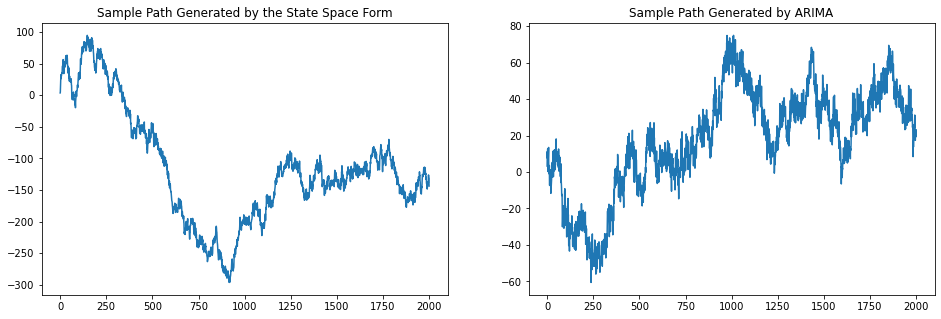

In [31]:
import numpy as np
from pandas import Series
from scipy.stats import norm
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

nsample = 2000

sw = np.sqrt(8)
sv = np.sqrt(20)

q = (sw/sv)**2
theta = (np.sqrt(q**2 + 4*q) - 2 - q)/2
sigma = np.sqrt((sv**2 + 2*sw**2)/(1 + theta**2))

np.random.seed(0)
v = norm(scale=sv).rvs(nsample)
w = norm(scale=sw).rvs(nsample)
m = v.cumsum()
y1 = m + w

y2 = ArmaProcess(ma=[1, theta]).generate_sample(nsample=nsample, scale=sigma).cumsum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
Series(y1).plot(ax=ax1, title='Sample Path Generated by the State Space Form')
Series(y2).plot(ax=ax2, title='Sample Path Generated by ARIMA')
plt.show()

## (d) {-}

The augmented Dickey-Fuller test shows that both `y1` and `y2` are $\mathcal I(1)$. 

In [23]:
import statsmodels.tsa.api as smt

[smt.stattools.adfuller(y)[1] for y in [y1, y2]]

[0.5300749189039846, 0.3641076297625432]

In [24]:
[smt.stattools.adfuller(np.diff(y))[1] for y in [y1, y2]]

[0.0, 0.0]

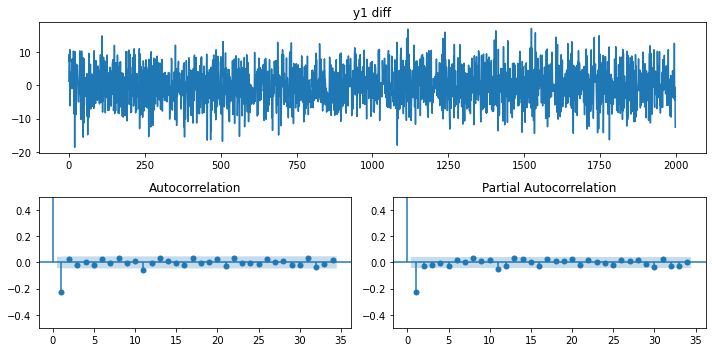

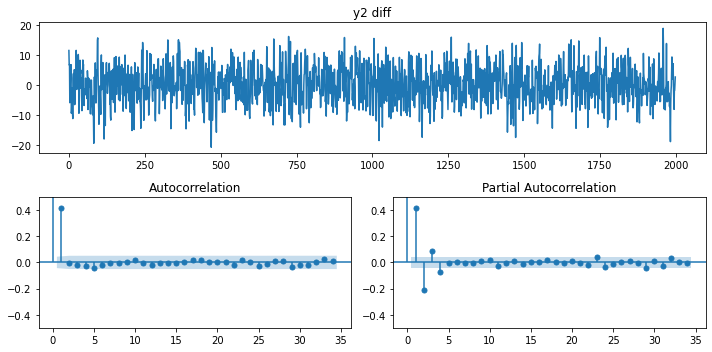

In [25]:
from statsmodels.tsa.arima_model import ARMA
from pandas import Series
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt

def tsplot(ts, title, acf_ylim=(-0.5, 0.5)):
    fig = plt.figure(figsize=(10, 5))
    layout = (2,2)
    ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    pacf_ax = plt.subplot2grid(layout, (1,1))
    acf_ax = plt.subplot2grid(layout, (1,0))

    Series(ts).plot(ax=ts_ax)
    smt.graphics.plot_acf(ts, ax=acf_ax)
    smt.graphics.plot_pacf(ts, ax=pacf_ax)
    ts_ax.set(title=title)
    pacf_ax.set(ylim=acf_ylim)
    acf_ax.set(ylim=acf_ylim)

    plt.tight_layout()
    plt.show()

tsplot(np.diff(y1), title='y1 diff')
tsplot(np.diff(y2), title='y2 diff')

Model selection on the differences gives the correct model order. 

In [7]:
res = smt.stattools.arma_order_select_ic(np.diff(y1), ic=['aic', 'bic'], trend='nc')
print('AIC min order: ', res.aic_min_order)
print('BIC min order: ', res.bic_min_order)

AIC min order:  (0, 1)
BIC min order:  (0, 1)


In [8]:
res = smt.stattools.arma_order_select_ic(np.diff(y2), ic=['aic', 'bic'], trend='nc')
print('AIC min order: ', res.aic_min_order)
print('BIC min order: ', res.bic_min_order)

AIC min order:  (0, 1)
BIC min order:  (0, 1)


In [26]:
from statsmodels.tsa.arima.model import ARIMA 

res = ARIMA(y1, order=(0, 1, 1)).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2000
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -6273.138
Date:                Fri, 07 May 2021   AIC                          12550.277
Time:                        17:21:57   BIC                          12561.478
Sample:                             0   HQIC                         12554.390
                               - 2000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2271      0.022    -10.421      0.000      -0.270      -0.184
sigma2        31.1363      1.037     30.032      0.000      29.104      33.168
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 3.28
Prob(Q):                              0.83   Prob(JB):                         0.19
Heteroskedasticity (H):               1.01   Skew:                            -0.02
Prob(H) (two-sided):                  0.86   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
from statsmodels.tsa.arima.model import ARIMA 

res = ARIMA(y2, order=(0, 1, 1)).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2000
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -6146.533
Date:                Fri, 07 May 2021   AIC                          12297.067
Time:                        17:23:50   BIC                          12308.268
Sample:                             0   HQIC                         12301.180
                               - 2000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5501      0.018    -29.827      0.000      -0.586      -0.514
sigma2        27.4275      0.894     30.678      0.000      25.675      29.180
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.13
Prob(Q):                              0.92   Prob(JB):                         0.57
Heteroskedasticity (H):               0.94   Skew:                             0.00
Prob(H) (two-sided):                  0.46   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""